/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 116.58256| val_0_rmse: 229.81011|  0:00:00s
epoch 1  | loss: 9.64714 | val_0_rmse: 90.17691|  0:00:01s
epoch 2  | loss: 3.98405 | val_0_rmse: 4.40541 |  0:00:02s
epoch 3  | loss: 3.55166 | val_0_rmse: 2.48303 |  0:00:03s
epoch 4  | loss: 3.29807 | val_0_rmse: 2.16365 |  0:00:03s
epoch 5  | loss: 3.26005 | val_0_rmse: 2.31132 |  0:00:04s
epoch 6  | loss: 3.26215 | val_0_rmse: 2.25485 |  0:00:05s
epoch 7  | loss: 3.19597 | val_0_rmse: 2.26218 |  0:00:06s
epoch 8  | loss: 3.22481 | val_0_rmse: 2.35203 |  0:00:07s
epoch 9  | loss: 3.19598 | val_0_rmse: 2.46948 |  0:00:07s
epoch 10 | loss: 3.1826  | val_0_rmse: 2.63551 |  0:00:08s
epoch 11 | loss: 3.16518 | val_0_rmse: 2.64075 |  0:00:09s
epoch 12 | loss: 3.18425 | val_0_rmse: 2.55675 |  0:00:10s
epoch 13 | loss: 3.14663 | val_0_rmse: 2.6373  |  0:00:10s
epoch 14 | loss: 3.18345 | val_0_rmse: 2.62175 |  0:00:11s

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_rmse = 2.16365


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


 TabNet - RMSE : 2.1636
 TabNet - R² Score : 0.1167


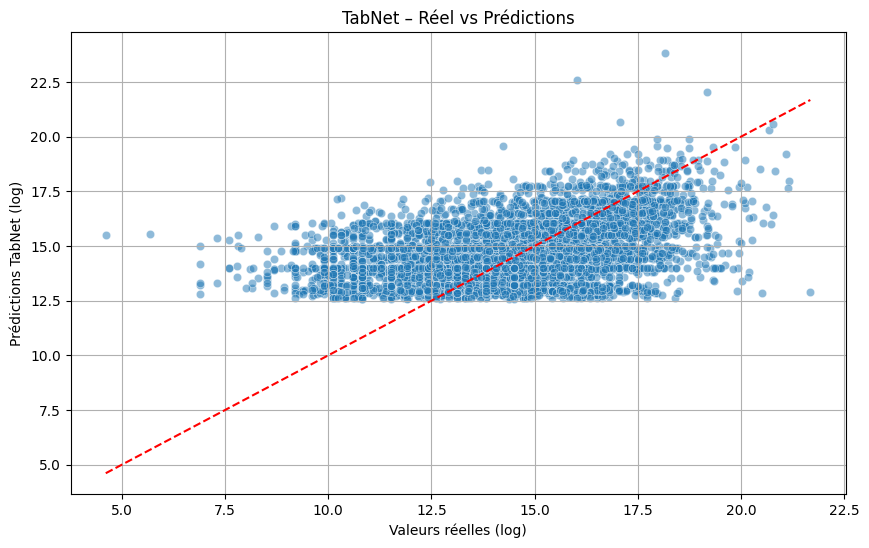

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from pytorch_tabnet.tab_model import TabNetRegressor


from sklearn.preprocessing import LabelEncoder


# Charger le dataset
path = "/Users/amar/Desktop/Alyra_School/Alyra 2025/4- Projet/investments_VC.csv"
df = pd.read_csv(path, encoding='unicode_escape')
df.columns = df.columns.str.strip().str.lower()

# Colonnes utiles
cols = ['country_code', 'market', 'category_list', 'funding_rounds', 'founded_year', 'funding_total_usd']
df = df[cols]

# Nettoyage montants
df['funding_total_usd'] = df['funding_total_usd'].replace(r'[\$,]', '', regex=True)
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')
df.dropna(inplace=True)
df = df[df['funding_total_usd'] > 0]

# Cible log
df['log_funding'] = np.log1p(df['funding_total_usd'])
y = df['log_funding']

# Encodage label pour colonnes catégorielles
X = df.drop(['funding_total_usd', 'log_funding'], axis=1).copy()

for col in ['country_code', 'market', 'category_list']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
# TabNet
tabnet_model = TabNetRegressor(seed=42)
tabnet_model.fit(X_train, y_train,
                 eval_set=[(X_test, y_test)],
                 eval_metric=['rmse'],
                 max_epochs=100,
                 patience=10,
                 batch_size=1024,
                 virtual_batch_size=128)

# Prédiction
y_pred = tabnet_model.predict(X_test).flatten()

# Évaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print(f" TabNet - RMSE : {rmse:.4f}")
print(f" TabNet - R² Score : {r2:.4f}")

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test.ravel(), y=y_pred.ravel(), alpha=0.5)
plt.plot([min(y_test.ravel()), max(y_test.ravel())], [min(y_test.ravel()), max(y_test.ravel())], 'r--')
plt.xlabel("Valeurs réelles (log)")
plt.ylabel("Prédictions TabNet (log)")
plt.title("TabNet – Réel vs Prédictions")
plt.grid(True)
plt.show()
